<center><h2>DSSP<br>Deep Learning - Convolution Neural Networks</h2><h3>1D Convolutional Neural Networks for Text Categorization</h3> 8 / 12/ 2020<br> K. Skianis, H. Abdine</center>

This part of the lab is largely based on Antoine Tixier's notes [Introduction to CNNs and LSTMs for NLP](https://arxiv.org/pdf/1808.09772.pdf). You are strongly encouraged to have a look at these notes for a quick theoretical intro.

In this part of the lab, we will implement a convolutional neural network (CNN) to perform binary movie review classification (positive/negative) using the [Keras](https://keras.io) library. The architecture of the CNN we will develop is described in [CNNs for Sentence Classification (Kim, EMNLP'14)](https://www.aclweb.org/anthology/D14-1181). We will also visualize document embeddings and predictive regions in the input documents, following [Effective Use of Word Order for Text Categorization with Convolutional Neural Networks (Johnson and Zhang, NAACL'15)](https://www.aclweb.org/anthology/N15-1011/), and first-order derivate saliency maps, following [Visualizing and Understanding Neural Models in NLP (Li et al., NAACL'16)](http://www.aclweb.org/anthology/N16-1082). 


### Reading data and preprocessing
For our experiments, we will use the [sentence polarity dataset](http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz). The dataset was collected by Pang and Lee and consists of 5,331 positive and 5,331 negative snippets acquired from Rotten Tomatoes. Snippets were automatically labeled using the labels provided by Rotten Tomatoes. The positive and negative reviews are stored into the `rt-polarity.pos` and `rt-polarity.neg` files, respectively. Let's first read the data.

In [ ]:
import urllib
from tensorflow.keras.utils import to_categorical

# Initialize lists for data and class labels
docs = list()
class_labels = list()

url = 'https://resourcesftp.blob.core.windows.net/files/dssp/deep_learning/data/rt-polarity.pos'
file = urllib.request.urlopen(url)

# For each row of the csv file
for line in file:
  docs.append(line.decode('utf-8', 'ignore'))
  class_labels.append(1)


url = 'https://resourcesftp.blob.core.windows.net/files/dssp/deep_learning/data/rt-polarity.neg'
file = urllib.request.urlopen(url)

# For each row of the csv file
for line in file:
  docs.append(line.decode('utf-8', 'ignore'))
  class_labels.append(0)

y = to_categorical(class_labels)

# your code here
print("first positive review: ", docs[0])
print("first negative review: ", docs[5331])

first positive review:  the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . 

first negative review:  simplistic , silly and tedious . 



The documents that are contained in the dataset have already undergone some preprocessing. Therefore, we will only remove some punctuation marks, diacritics, and non letters, if any. Furthermore, we will represent each document as a list of tokens. Use the ``preprocessing`` function (already implemented) to preprocess the documents.

Task:
- print a positive and negative document

In [ ]:
import re

def clean_str(string):
  string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
  string = re.sub(r"\'s", " \'s", string) 
  string = re.sub(r"\'ve", " \'ve", string) 
  string = re.sub(r"n\'t", " n\'t", string) 
  string = re.sub(r"\'re", " \'re", string) 
  string = re.sub(r"\'d", " \'d", string) 
  string = re.sub(r"\'ll", " \'ll", string) 
  string = re.sub(r",", " , ", string) 
  string = re.sub(r"!", " ! ", string) 
  string = re.sub(r"\(", " \( ", string) 
  string = re.sub(r"\)", " \) ", string) 
  string = re.sub(r"\?", " \? ", string) 
  string = re.sub(r"\s{2,}", " ", string)
  return string.strip().split()

    
def preprocessing(docs):
  preprocessed_docs = []

  for doc in docs:
    preprocessed_docs.append(clean_str(doc))

  return preprocessed_docs


#your code here
preprocessed_docs = preprocessing(docs)
print('review:', preprocessed_docs[0])
print('label: ', y[0])

print('review:', preprocessed_docs[6000])
print('label: ', y[6000])


review: ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', 'conan', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean', 'claud', 'van', 'damme', 'or', 'steven', 'segal']
label:  [0. 1.]
review: ['as', 'the', 'movie', 'dragged', 'on', ',', 'i', 'thought', 'i', 'heard', 'a', 'mysterious', 'voice', ',', 'and', 'felt', 'myself', 'powerfully', 'drawn', 'toward', 'the', 'light', 'the', 'light', 'of', 'the', 'exit', 'sign', 'i', 'have', 'returned', 'from', 'the', 'beyond', 'to', 'warn', 'you', 'this', 'movie', 'is', '90', 'minutes', 'long', ',', 'and', 'life', 'is', 'too', 'short']
label:  [1. 0.]


Subsequently, we will extract the vocabulary of the dataset. We will store the vocabulary in a dictionary where keys are terms and values correspond to indices. Hence, each term will be assigned a unique index. The minimum index will be equal to 1, while the maximum index will be equal to the size of the vocabulary.

Task:
- get the vocabulary and print it

In [ ]:
def get_vocab(processed_docs):
  vocab = dict()

  for doc in processed_docs:
    for word in doc:
      if word not in vocab:
        vocab[word] = len(vocab) + 1

  return vocab

# your code here
vocab = get_vocab(preprocessed_docs)
print(vocab.items())

dict_items([('the', 1), ('rock', 2), ('is', 3), ('destined', 4), ('to', 5), ('be', 6), ('21st', 7), ('century', 8), ("'s", 9), ('new', 10), ('conan', 11), ('and', 12), ('that', 13), ('he', 14), ('going', 15), ('make', 16), ('a', 17), ('splash', 18), ('even', 19), ('greater', 20), ('than', 21), ('arnold', 22), ('schwarzenegger', 23), (',', 24), ('jean', 25), ('claud', 26), ('van', 27), ('damme', 28), ('or', 29), ('steven', 30), ('segal', 31), ('gorgeously', 32), ('elaborate', 33), ('continuation', 34), ('of', 35), ('lord', 36), ('rings', 37), ('trilogy', 38), ('so', 39), ('huge', 40), ('column', 41), ('words', 42), ('cannot', 43), ('adequately', 44), ('describe', 45), ('co', 46), ('writer', 47), ('director', 48), ('peter', 49), ('jackson', 50), ('expanded', 51), ('vision', 52), ('j', 53), ('r', 54), ('tolkien', 55), ('middle', 56), ('earth', 57), ('effective', 58), ('but', 59), ('too', 60), ('tepid', 61), ('biopic', 62), ('if', 63), ('you', 64), ('sometimes', 65), ('like', 66), ('go', 6

Next, we will load a set of 300-dimensional word embeddings learned with word2vec on the GoogleNews dataset. The embeddings can be downloaded from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit. Using `gensim`, we can extract only the vectors of the words found in our vocabulary. Terms not present in the set of pre-trained words are initialized randomly (uniformly in [−0.25, 0.25]). Before executing the code, set the path for the file that contains the word embeddings.

In [ ]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-12-08 14:18:50--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.18.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.18.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  44.0MB/s    in 36s     

2020-12-08 14:19:27 (43.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [ ]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors

def load_embeddings(fname, vocab):
  embeddings = np.zeros((len(vocab)+1, 300))
  
  model = KeyedVectors.load_word2vec_format(fname, binary=True)
  for word in vocab:
    if word in model:
      embeddings[vocab[word]] = model[word]
    else:
      embeddings[vocab[word]] = np.random.uniform(-0.25, 0.25, 300)

  return embeddings


path_to_embeddings = 'GoogleNews-vectors-negative300.bin.gz'
embeddings = load_embeddings(path_to_embeddings, vocab)

We will now calculate the size of the largest document and create a matrix whose rows correspond to documents. Each row contains the indices of the terms appearing in the document and preserves the order of the terms in the document. That is, the first component of a row contains the index of the first term of the corresponding document, the second component contains the index of the second term etc. Documents whose length is shorter than that of the longest document are padded with zeros.

In [ ]:
#your code here
max_len = 0
for doc in preprocessed_docs:
  max_len = np.max((len(doc), max_len))
print('The length of the largest document is: ', max_len)

X = np.zeros((len(preprocessed_docs), max_len))
for i, doc in enumerate(preprocessed_docs):
  for j, word in enumerate(doc):
    X[i][j] = vocab[word]

The length of the largest document is:  56


We will then use the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function of scikit-learn to split our dataset randomly into a training and a test set. Set the size of the test set to 0.1 and the random_state to 91.

In [ ]:
from sklearn.model_selection import train_test_split

#your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=91)

## Defining the CNN
For efficiency reasons, we will only implement two branches of the following architecture: 

<img src="https://resourcesftp.blob.core.windows.net/files/dssp/deep_learning/figures/cnn_illustration.png"/>

A branch is the part of the architecture that corresponds to a given filter size (e.g., the upper red part is one branch).

Up until now, we have only made use of the Sequential model. The Sequential model offers limited flexibility and may not be suitable for neural networks with multiple inputs and outputs. On the other hand, the [functional API](https://keras.io/getting-started/functional-api-guide/) makes it easy to manipulate a large number of intertwined datastreams. Our CNN consists of two branches whose outputs are concatenated to produce a single vector representation for each document (i.e., the multicolor vector shown in the figure above). We will use the functional API to implement the CNN. Unlike the Sequential model, in the case of the functional API it is necessary to create and define a standalone Input layer that specifies the shape of input data. The input layer takes as input a tuple that indicates the dimensionality of the input data. When the input data is one-dimensional (as in our case), the shape must explicitly leave room for the shape of the mini-batch size. Therefore, the shape tuple is always defined with a hanging last dimension when the input is one-dimensional:
```
my_input = Input(shape=(dimension,))
```

In [ ]:
from tensorflow.keras.layers import Input

#your code here
my_input = Input(shape=(max_len,))

The layers in the model are connected pairwise. Hence, each layer takes as input either the input data (e.g., the input layer) or the output of another layer. We will first define and [Embedding layer](https://keras.io/layers/embeddings/). The Embedding layer requires the input data to be integer encoded, so that each word is represented by a unique integer. The Embedding layer can be initialized either with random weights and learn an embedding for all of the words in the training set or with pre-trained word embeddings. In our case, it will be initialized with the 300-dimensional word embeddings that we have already loaded. The Embedding layer must specify 3 arguments: (1) `input_dim`: the size of the vocabulary, (2) `output_dim`: the size of the vector space in which the words have been embedded (i.e., 300 in our case), and (3) `input_length`: the maximum length of the input documents. In case we initialize the layer with pre-trained embeddings, we must provide another argument (`weights`) which is list that contains a matrix whose i-th row contain the embedding of term with index i. For example, below we define an Embedding layer with a vocabulary of 100, embedding dimensionality equal to 64, maximum length of the input documents equal to 50, and the embeddings are contained in the matrix embed_matrix.
```
embedding = Embedding(input_dim=100,
                      output_dim=64,
                      weights=[embed_matrix],
                      input_length=50
                      ) (my_input)
```

Note that we also specify where the input comes from when defining a layer. Implement the embedding layer of the CNN.

In [ ]:
from tensorflow.keras.layers import Embedding

#your code here
embedding = Embedding(input_dim=len(vocab)+1,
                      output_dim=300,
                      weights=[embeddings],
                      input_length=max_len
                      )(my_input)

We next create the two branches of the CNN. Each branch takes as input the output of the Embedding layer and applies a [one-dimensional convolution layer](https://keras.io/layers/convolutional/#conv1d) followed by a [one-dimensional max-pooling operation](https://keras.io/layers/pooling/#maxpooling1d). 

The one-dimensional convolution layer must specify 3 arguments: (1) `filters`: the number of filters, (2) `kernel_size`: the length of the one-dimensional convolution window, and (3) `activation`: the activation function to use. For example, below we define an one-dimensional convolution layer with 100 filters, a convolution window of size 4, and a ReLU activation function.
```
conv = Conv1D(filters = 100,
              kernel_size = 4,
              activation = 'relu',
              )(embedding)
```

The one-dimensional max-pooling operation just takes as input the output of the convolution layer. Implement the two branches of the CNN. For each branch, implement a one-dimensional convolution layer and a one-dimensional max-pooling operation. Use 100 filters and set the size of the filters of the first branch to 3 and the size of the filters of the second branch to 4. 

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

#your code here
conv3 = Conv1D(filters=100,
               kernel_size=3,
               activation='relu',
               )(embedding)

conv4 = Conv1D(filters=100,
               kernel_size=4,
               activation='relu',
               )(embedding)

maxpool3 = GlobalMaxPooling1D()(conv3)

maxpool4 = GlobalMaxPooling1D()(conv4)

We next introduce a layer that [concatenates](https://keras.io/layers/merge/#concatenate_1) the outputs of the two branches. This layer takes as input the two vectors that were produced from the two branches and returns a single vector, the concatenation of the two inputs. We then add dropout (rate equal to 0.5) and finally a fully-connected neural network with 2 neurons that will serve as out ouput.

In [ ]:
from tensorflow.keras.layers import Dropout, Dense, Concatenate

#your code here
conc = Concatenate()([maxpool3, maxpool4])
res = Dropout(0.5)(conc)
res = Dense(2, activation='softmax')(res)


After creating all of the layers and connecting them together, we can define the model. Keras provides a [Model class](https://keras.io/models/model/) that we can use to create a model from your created layers. It requires that you only specify the input and output layers. For example, given the an input and an output, we can define the model as follows:
```
model = Model(input, output)
```
After creating the model, you can compile it. Use the Adam optimizer to minimize the categorical crossentropy.

In [ ]:
from tensorflow.keras.models import Model

#your code here
model = Model(my_input, res)

We finally print the details of the CNN.

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 56)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 56, 300)      5633400     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 54, 100)      90100       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 53, 100)      120100      embedding[0][0]                  
_______________________________________________________________________________________

### Visualization of document embeddings before training
We extract the output of the final embedding layer (before the softmax), which gives the encoding of the input document for some documents (`n_plot`) of the test set. We then visualize a low-dimensional map of the embeddings. We can see that before training, the documents are dispersed randomly in the space (which makes sense).

plotting embeddings of first 1000 documents


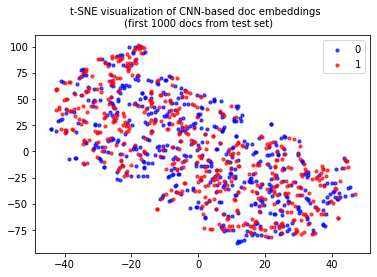

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras import backend as K

# in test mode, we should set the 'learning_phase' flag to 0 (we don't want to use dropout)
get_doc_embedding = K.function(model.inputs,
                               [model.layers[6].output])

n_plot = 1000
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(X_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

labels_plt = y_test[:n_plot,0].astype(np.int32)
my_colors = ['blue','red']

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
  idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
  ax.scatter(doc_emb_tsne[idxs,0], 
              doc_emb_tsne[idxs,1], 
              c = my_colors[label],
              label=str(label),
              alpha=0.7,
              s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)

### Train the CNN
We train the model on CPU. Set the batch size to 64 and the number of epochs to 10. Note you can get a significant speedup by using a GPU. We also add two callbacks:
* the first one ensures that training stops after 2 epochs without improvement in test set accuracy (early stopping strategy)
* the second one (checkpointer) saves the model to disk for every epoch for which there is improvement. Therefore, at the end of training, the model saved on disk will be the one corresponding to the best epoch and we can reload it.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_accuracy', # go through epochs as long as accuracy on validation set increases
                               patience=2,
                               mode='max')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath='cnn_text_categorization.hdf5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               verbose=0)


#your code here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(np.array(X_train),
          y_train,
          batch_size = 64,
          epochs = 10,
          callbacks=[early_stopping, checkpointer],
          validation_data = (np.array(X_test), y_test))

Epoch 1/10
150/150 [==============================] - 32s 213ms/step - loss: 0.5743 - accuracy: 0.6972 - val_loss: 0.4284 - val_accuracy: 0.7966
Epoch 2/10
150/150 [==============================] - 32s 211ms/step - loss: 0.3361 - accuracy: 0.8591 - val_loss: 0.4044 - val_accuracy: 0.8088
Epoch 3/10
150/150 [==============================] - 32s 211ms/step - loss: 0.1842 - accuracy: 0.9361 - val_loss: 0.4272 - val_accuracy: 0.8116
Epoch 4/10
150/150 [==============================] - 31s 210ms/step - loss: 0.0868 - accuracy: 0.9769 - val_loss: 0.4976 - val_accuracy: 0.8051
Epoch 5/10
150/150 [==============================] - 34s 225ms/step - loss: 0.0420 - accuracy: 0.9909 - val_loss: 0.5661 - val_accuracy: 0.7976


We want to make sure we load the model corresponding to the best epoch.

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('cnn_text_categorization.hdf5')

### Visualization of document embeddings after training
We can see that after only a few epochs, our model has already learned meaningful internal representations:

plotting embeddings of first 1000 documents


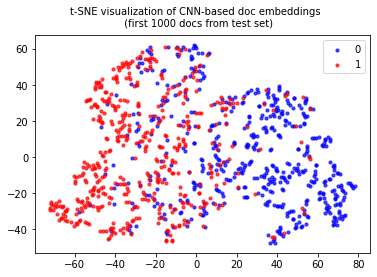

In [ ]:
print('plotting embeddings of first',n_plot,'documents')

doc_emb = get_doc_embedding([np.array(X_test[:n_plot]),0])[0]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10)
doc_emb_pca = my_pca.fit_transform(doc_emb) 
doc_emb_tsne = my_tsne.fit_transform(doc_emb_pca)

fig, ax = plt.subplots()

for label in list(set(labels_plt)):
  idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
  ax.scatter(doc_emb_tsne[idxs,0], 
              doc_emb_tsne[idxs,1], 
              c = my_colors[label],
              label=str(label),
              alpha=0.7,
              s=10)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of CNN-based doc embeddings \n (first 1000 docs from test set)',fontsize=10)
fig.set_size_inches(6,4)

### Predictive text regions
Here we follow the approach of [Effective Use of Word Order for Text Categorization with Convolutional Neural Networks (Johnson and Zhang, NAACL'15)](https://www.aclweb.org/anthology/N15-1011/) (see Tables 5 and 6).

The feature maps that we find at the output of the convolutional layer provide region embeddings (in an `nb_filters`-dimensional space). For a given branch associated with `filter_size`, there are `max_size-filter_size+1` regions of size `filter_size` for an input of size `max_size`. For a given document, we want to identify the `n_show` regions of each branch that are associated with the highest weights in the corresponding feature maps. 

We can see that to classify the test set documents (which the model has never seen), the CNN uses regions of the input documents that make sense to us as humans. It picks up the compliments (`"glaring and unforgettable"`, `"a good yarn spinner"`) and critics (`"not merely unwatchable"`, `"but feeling pandered"`).

In [ ]:
def extract_regions(tokens, filter_size):
  regions = []
  regions.append(' '.join(tokens[:filter_size]))
  for i in range(filter_size, len(tokens)):
    regions.append(' '.join(tokens[(i-filter_size+1):(i+1)]))
  return regions

index_to_word = dict()
for word in vocab:
  index_to_word[vocab[word]] = word

filter_size_a = 3
filter_size_b = 4

get_region_embedding_a = K.function(model.inputs,
                                    [model.layers[2].output])

get_region_embedding_b = K.function(model.inputs,
                                    [model.layers[3].output])

get_softmax = K.function(model.inputs,
                         [model.layers[8].output])

n_doc_per_label = 2
idx_pos = [idx for idx in range(y_test.shape[0]) if y_test[idx,0]==1]
idx_neg = [idx for idx in range(y_test.shape[0]) if y_test[idx,0]==0]
my_idxs = idx_pos[:n_doc_per_label] + idx_neg[:n_doc_per_label]

X_test_my_idxs = np.array([X_test[elt] for elt in my_idxs])
y_test_my_idxs = [y_test[elt] for elt in my_idxs]

reg_emb_a = get_region_embedding_a([X_test_my_idxs,0])[0]
reg_emb_b = get_region_embedding_b([X_test_my_idxs,0])[0]

# predictions are probabilities of belonging to class 1
predictions = get_softmax([X_test_my_idxs,0])[0] 
# note: you can also use directly: predictions = model.predict(x_test[:100]).tolist()

n_show = 3 # number of most predictive regions we want to display

for idx,doc in enumerate(X_test_my_idxs):
  tokens = [index_to_word[elt] for elt in doc if elt!=0] # the 0 index is for padding
  
  # extract regions (sliding window over text)
  regions_a = extract_regions(tokens, filter_size_a)
  regions_b = extract_regions(tokens, filter_size_b)
  
  print('\n *********')
  print('===== text: =====')
  print(' '.join(tokens))
  print('===== label:',y_test_my_idxs[idx],'=====')
  print('===== prediction:',predictions[idx],'=====')
  norms_a = np.linalg.norm(reg_emb_a[idx,:,:],axis=1)
  norms_b = np.linalg.norm(reg_emb_b[idx,:,:],axis=1)
  print('===== most predictive regions of size',filter_size_a,': =====')
  print([elt for idxx,elt in enumerate(regions_a) if idxx in np.argsort(norms_a)[-n_show:]]) # 'np.argsort' sorts by increasing order
  print('===== most predictive regions of size',filter_size_b,': =====')
  print([elt for idxx,elt in enumerate(regions_b) if idxx in np.argsort(norms_b)[-n_show:]])


 *********
===== text: =====
a lousy movie that 's not merely unwatchable , but also unlistenable
===== label: [1. 0.] =====
===== prediction: [9.9974793e-01 2.5201921e-04] =====
===== most predictive regions of size 3 : =====
['lousy movie that', 'not merely unwatchable', 'unwatchable , but']
===== most predictive regions of size 4 : =====
['a lousy movie that', "'s not merely unwatchable", 'merely unwatchable , but']

 *********
===== text: =====
one of those movies where you walk out of the theater not feeling cheated exactly , but feeling pandered to , which , in the end , might be all the more infuriating
===== label: [1. 0.] =====
===== prediction: [0.9220643  0.07793567] =====
===== most predictive regions of size 3 : =====
['the theater not', 'but feeling pandered', 'feeling pandered to']
===== most predictive regions of size 4 : =====
['theater not feeling cheated', 'but feeling pandered to', 'pandered to , which']

 *********
===== text: =====
fierce , glaring and unforgetta

### Saliency maps
Here we follow one of the approaches proposed in [Visualizing and Understanding Neural Models in NLP (Li et al., NAACL'16)](http://www.aclweb.org/anthology/N16-1082).

The idea is to rank the elements of the input document based on their influence on the prediction. An approximation can be given by the magnitudes of the first-order partial derivatives of the output of the model with respect to each word in the input document. The interpretation is that we identify which words in the document need to be *changed the least to change the class score the most*. The derivatives can be obtained by performing a single back-propagation pass. Note that here, we backpropagate the class score and not the loss (like we do during training).

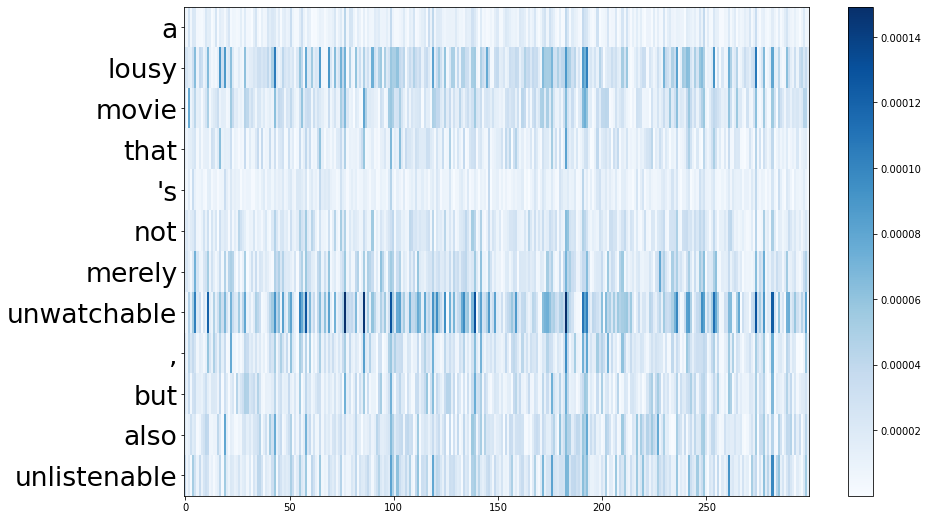

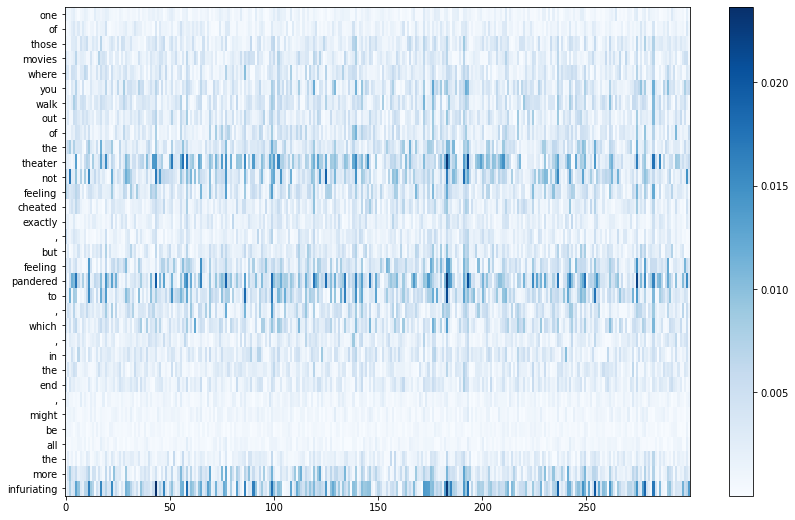

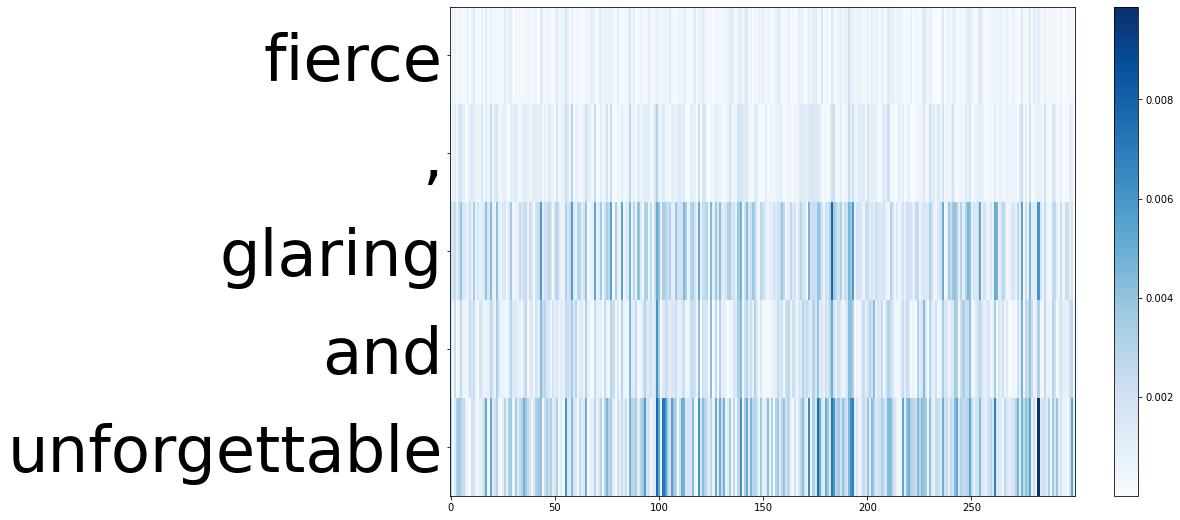

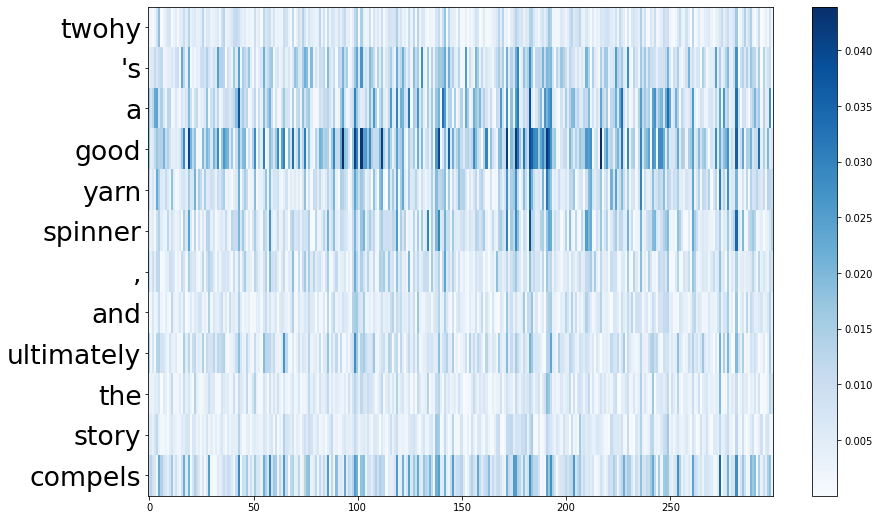

In [ ]:
saliency_input = model.layers[1].output # before split into branches
saliency_output = model.layers[8].output[:,0] # class score
gradients = model.optimizer.get_gradients(saliency_output,saliency_input)
compute_gradients = K.function(inputs=model.inputs,outputs=gradients)

for idx,doc in enumerate(X_test_my_idxs):
  matrix = compute_gradients([np.array([doc]),0])[0][0,:,:]
  tokens = [index_to_word[elt] for elt in doc if elt!=0]
  to_plot = np.absolute(matrix[:len(tokens),:])
  fig, ax = plt.subplots()
  heatmap = ax.imshow(to_plot, cmap=plt.cm.Blues, interpolation='nearest',aspect='auto')
  ax.set_yticks(np.arange(len(tokens)))
  ax.set_yticklabels(tokens)
  ax.tick_params(axis='y', which='major', labelsize=32*10/len(tokens))
  fig.colorbar(heatmap)
  fig.set_size_inches(14,9)

## Distances in word embeddings

<img src="https://miro.medium.com/max/890/1*nTWAm46JMYWXpHVsS9MA5w.png"/>

Compute the cosine similarity with mean embeddings and word mover's distance with gensim. First create a function for getting the mean embedding given a sentence.


In [ ]:
from scipy.spatial import distance
from gensim.similarities import WmdSimilarity

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

## your code 
inp = ''
for text in docs:
  inp += text + "\n"

text_file = open("corpus.txt","w")
text_file.write(inp)
text_file.close()

line_sentence = LineSentence('corpus.txt',9999999)

model = Word2Vec(size=100, workers=4, min_count=5, window=5, sg=0)
model.build_vocab(line_sentence)

model.train(line_sentence, total_examples=model.corpus_count, epochs=10)


(1327117, 2240010)

In [ ]:
path_to_embeddings = 'GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(path_to_embeddings, binary=True)

model.wv.similarity('movie','film')

model.wv.most_similar(positive=['best', 'good'], negative=['worst'])

model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

In [ ]:
sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'

def get_mean_vector(sentence):
  vectors = []
  for word in sentence:
    if word in model.wv.vocab:
      vectors.append(model[word])
  
  vectors = np.array(vectors)
  mean_vector = np.mean(vectors, axis=0)
  return mean_vector

v1 = get_mean_vector(sentence_obama.lower().split())
v2 = get_mean_vector(sentence_president.lower().split())

cos_sim = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
print(cos_sim)

dist = model.wmdistance(sentence_obama.split(), sentence_president.split())


0.67692727


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
